In [1]:
%load_ext itikz
import itikz
from itikz import nicematrix as nM
import jinja2

import numpy as np
import sympy as sym

import os
import tempfile
from pathlib import Path

from IPython.display import display
import logging
class JupyterHandler(logging.Handler):
    def _get_jupyter_level(self, level):
        level_name = logging.getLevelName(level)
        return level_name.lower()
        
    def emit(self, record):
        message = self.format(record)
        data = {
            'application/vnd.jupyterlab.log': {
                'type': 'text',
                'data': message,
                'level': self._get_jupyter_level(record.levelno)
            }
        }
        display(data, raw=True)

rootLogger = logging.getLogger()

rootLogger.setLevel(logging.INFO)
handler = JupyterHandler()
handler.setLevel(logging.INFO)
rootLogger.addHandler(handler)

#rootLogger.warning("HI")

In [2]:
np.random.seed(112244)
def gen_matrix(m,n):
    return np.random.randint( low=1,high=9, size=(m,n))

A0 = None;             A1 = gen_matrix(2,3); A2=gen_matrix(3,2);   A3=gen_matrix(2,1)
B0 = gen_matrix(2,2);  B1 = B0 @ A1;         B2= B1 @ A2;          B3=B2 @ A3
#C0 = gen_matrix(1,2);  C1 = C0 @ B1;         C2= C1 @ B2

#      -   (2,3) (3,2)   => COLS:  2 3 2
#    (2,2) (2,3) (2,2)   => ROWS:  3 2

layers=[ [A0, A1, A2, A3],
         [B0, B1, B2, B3],
       ]

# MatrixGridLayout

In [3]:
#%load itikz/nicematrix.py

| | | | |
| --- | --- | --- | --- |
|     |       | y y |   |
|     | x x x | y y |z |
|     | x x x | y y |z |
| a a | * * * | * * |# |
| a a | * * * | * * |# |

In [3]:
def testMatrixGridLayout():
    mm = nM.MatrixGridLayout(layers, extra_cols=[1,0,0,0,3], extra_rows=[0,0,0])
    mm.describe()
    print()
    #print( 'no partition:', MatrixGridLayout.matrix_array_format( 5 ))
    #print( 'partition:   ', MatrixGridLayout.matrix_array_format( 5, vpartitions=[1,3,4] ))
    #print()
    print('Top Left : Bottom Right Corners')
    for i in range(mm.nGridRows):
        for j in range(mm.nGridCols):
            tl,br,_ = mm._top_left_bottom_right(i,j)
            print( f"  {tl}:{br}", end='')
        print()
    # ====================================================================
    # Process the Matrix Grid for Display
    # ====================================================================
    mm.array_format_string_list( partitions={ 1:[2], 2:[1]} )
    mm.array_of_tex_entries()
    mm.nm_submatrix_locs()
    
    red   = nM.make_decorator( text_color='red' )    
    boxbf = nM.make_decorator( boxed=True, bf=True)
    bg    = nM.make_decorator( text_bg="red!15")

    mm.decorate_tex_entries( 0,3, red,   entries=None )
    mm.decorate_tex_entries( 1,2, boxbf, entries= [(1,0),(0,1)])
    mm.decorate_tex_entries( 1,1, bg,    entries=[(0,0),(1,1)] )

    #mm.decorate_tex_entries( 1,2, lambda a: '\\boxed{{ {a} }}'.format(a=a), entries= [(1,0),(0,1)])

    mm.tex_repr( blockseps = r'\noalign{\vskip2mm} ')

    # ====================================================================

    print("% -------------------------------------")
    print(f"format: {mm.format}");
    print("% -------------------------------------")
    print("LaTeX representation of the matrix")
    for l in mm.tex_list:
        print(l)
    print("% -------------------------------------")
    print("Submatrices:", mm.locs )
    print("% -------------------------------------")

    return mm

# Example mX: Single Matrix, Extra Rows

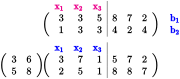

In [4]:
mX = nM.MatrixGridLayout([[None, gen_matrix(2,6)],[gen_matrix(2,2), gen_matrix(2,6)]], extra_cols=1, extra_rows=[1,1,0])
mX.array_format_string_list( partitions={ 1:[3]} )
mX.array_of_tex_entries()

mX.add_row_above(0,1,['x_1','x_2','x_3'], formater = lambda a: '\\color{{magenta}}{{\\mathbf{{ {a} }}}}'.format(a=a))
mX.add_row_below(0,1,['x_1','x_2','x_3'], formater = lambda a: '\\color{{blue}}{{\\mathbf{{ {a} }}}}'.format(a=a))

mX.add_col_right(0,1,['b_1','b_2'], formater = lambda a: '\\color{{blue}}{{\\mathbf{{ {a} }}}}'.format(a=a))

mX.nm_submatrix_locs()


mX.tex_repr( blockseps = r'\noalign{\vskip2mm} ')
mX_code = mX.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
        mX_code, prefix='mX_', working_dir="/tmp", debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file="tmp/foo" )
h

# Example m1

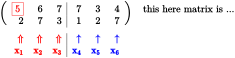

In [5]:
m1 = nM.MatrixGridLayout(gen_matrix(2,6), extra_cols=1, extra_rows=2)
m1.array_format_string_list( partitions={ 1:[3]} )
m1.array_of_tex_entries()
m1.decorate_tex_entries( 0,1, lambda a: '\\color{{red}}{{ \\boxed{{{a}}} }}'.format(a=a), entries=[(0,0)] )

blue = nM.make_decorator(text_color='blue', bf=True)
red  = nM.make_decorator(text_color='red',  bf=True)

typ = [red(r'\Uparrow'),red(r'\Uparrow'),red(r'\Uparrow'),blue(r'\uparrow'),blue(r'\uparrow'),blue(r'\uparrow')]
var = [red('x_1'),      red('x_2'),      red('x_3'),      blue('x_4'),      blue('x_5'),      blue('x_6')]

m1.add_row_below(0,1,typ, formater=lambda a: a )
m1.add_row_below(0,1,var, offset=1, formater=lambda a: a )

m1.nm_text( ['this here matrix is ...'])
m1.nm_submatrix_locs()
m1.tex_repr( blockseps = r'\noalign{\vskip2mm} ')

m1_code = m1.nm_latexdoc()

working_dir = os.path.join( os.getcwd(), "tmp" )
keep_file   = os.path.join( working_dir, "m1" )
h = itikz.fetch_or_compile_svg(
        m1_code, prefix='m1_', working_dir=working_dir, debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file=keep_file )
h

# Example m2

In [6]:
m2=testMatrixGridLayout()

Layout 2 x 4 grid:
.  insert extra_cols:            [1, 0, 0, 0, 3]
.  col_start                   = [ 1  3  6  8 12]
.  row_start                   = [0 3 5]

Consistent Matrix Sizes in the grid
  (3, 2)  (3, 3)  (3, 2)  (3, 1)
  (2, 2)  (2, 3)  (2, 2)  (2, 1)
Actual TopLeft:BottomRight Indices
  (3, 3):(2, 2)  (1, 3):(2, 5)  (0, 6):(2, 7)  (1, 8):(2, 8)
  (3, 1):(4, 2)  (3, 3):(4, 5)  (3, 6):(4, 7)  (3, 8):(4, 8)

Top Left : Bottom Right Corners
  (3, 3):(2, 2)  (1, 3):(2, 5)  (0, 6):(2, 7)  (1, 8):(2, 8)
  (3, 1):(4, 2)  (3, 3):(4, 5)  (3, 6):(4, 7)  (3, 8):(4, 8)
% -------------------------------------
format: r@{\qquad\ }*2r@{\qquad\ }*2rI*1r@{\qquad\ }*1rI*1r@{\qquad\ }*1r@{\qquad\ }rrl@{\qquad\;\;}
% -------------------------------------
LaTeX representation of the matrix
 &  &  &  &  &  & 1 & 2 &  &  &  &  \\
 &  &  & 7 & 5 & 6 & 4 & 3 & \color{red}{3} &  &  &  \\
 &  &  & 4 & 8 & 1 & 2 & 5 & \color{red}{5} &  &  &  \\ \noalign{\vskip2mm} 
 & 4 & 7 & \Block[draw=black,fill=red!

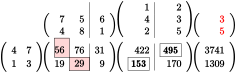

In [7]:
m2_latex_doc = m2.nm_latexdoc(template = nM.GE_TEMPLATE, preamble = nM.preamble, extension = nM.extension )

working_dir = os.path.join( os.getcwd(), "tmp" )
keep_file   = os.path.join( working_dir, "m2" )
h = itikz.fetch_or_compile_svg(
        m2_latex_doc, prefix='m2_', working_dir=working_dir, debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file=keep_file )
h

# Example m3

In [8]:
k  = sym.Symbol('k'); h = sym.Symbol('h')
Ab = sym.Matrix([[1,2,4,1],[2,k,8,h],[3,7,3,1]]); matrices = [[None, Ab]]; pivots = []; txt=[]
# we could use row ops, but we want a computational layout (and hence the E matrices!):
#    A=A.elementary_row_op('n->n+km', k=-3, row1=2,row2=0 );A
#    A=A.elementary_row_op('n<->m',row1=1,row2=2);A

E1=sym.eye(3);E1[1:,0]=[-2,-3]; A1=E1*Ab;                               matrices.append([E1,A1]); pivots.append((1,1));txt.append('Pivot at (1,1)')
E2=sym.eye(3);E2=E2.elementary_row_op('n<->m',row1=1,row2=2); A2=E2*A1; matrices.append([E2,A2]); pivots.append(None); txt.append('Rows 2 <-> 3')
E3=sym.eye(3);E3[2,1]=4-k; A3=E3*A2;                                    matrices.append([E3,A3]); pivots.append((2,2));txt.append('Pivot at (2,2)')
pivots.append((3,3)); txt.append('In Row Echelon Form')

if False:
    mat_rep, submatrix_locs, pivot_locs, path_corners, txt_with_locs,mat_format = \
       nM.ge_layout( matrices, Nrhs=1, pivots=pivots, txt=txt, decorate=True,\
                     formater=lambda x: sym.latex(x))

    mat_options = r"""[ code-before =
        {
        % ----------------------------------------------------------------------- Row-echelon form Path
        \tikz \draw[red] """ + " -- ".join( path_corners )+ " ; } ]"

    h =\
    itikz.fetch_or_compile_svg( jinja2.Template( nM.GE_TEMPLATE ).render( preamble=nM.preamble, extension=nM.extension,
                                                                          mat_rep=mat_rep, mat_format=mat_format, mat_options=mat_options,
                                                                          submatrix_locs=submatrix_locs, pivot_locs=pivot_locs, txt_with_locs=txt_with_locs),
                                prefix='sol_rhs_', working_dir='/tmp/itikz', debug=False,
                                **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True), nexec=4, keep_file="/tmp/foo" )
    display(h)

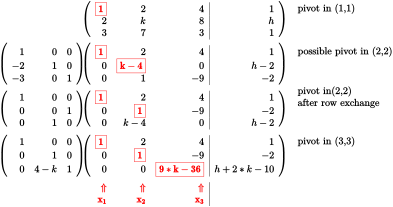

In [10]:
h,m = nM.ge( matrices, Nrhs=1,
               pivot_list=[ [(0,1), [(0,0)] ],
                            [(1,1), [(0,0),(1,1)]],
                            [(2,1), [(0,0),(1,1)]],
                            [(3,1), [(0,0),(1,1),(2,2)]]
                          ],
               comment_list = ["pivot in (1,1)", "possible pivot in (2,2)", r"pivot in(2,2)\\ \qquad after row exchange","pivot in (3,3)"],
              variable_summary = [True,True,True]
)
h

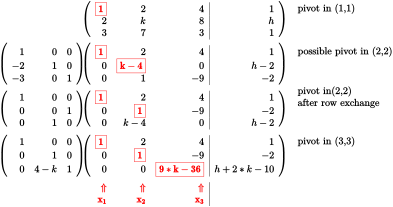

In [11]:
h = itikz.fetch_or_compile_svg(
        m.nm_latexdoc(), prefix='m_', working_dir=None, debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file=None )
h

# Fancy QR Example

Could not copy files


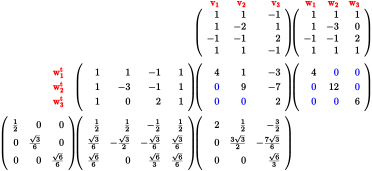

In [13]:
A = sym.Matrix([[ 1,  1, -1],
                [ 1, -2,  1],
                [-1, -1,  2],
                [ 1,  1, -1]])
W = sym.Matrix([[ 1,  1,  1],
                [ 1, -3,  0],
                [-1, -1,  2],
                [ 1,  1,  1]])
WtW  = W.T @ W
WtA  = W.T @ A
S    = WtW**(-1)
for i in range(S.shape[0]):
    S[i,i]=sym.sqrt(S[i,i])

Qt = S*W.T
R  = S*WtA

mZ = nM.MatrixGridLayout( [ [ None,  None,   A,    W ],
                            [ None,   W.T, WtA,  WtW ],
                            [ S,       Qt,   R, None ]
                     ], extra_rows = [1,0,0,0])

mZ.array_format_string_list()
mZ.array_of_tex_entries(formater=sym.latex)

blue    = nM.make_decorator(text_color='blue' )
for spec in [ [(1,2), [(1,0),(2,0),(2,1)]], [(1,3), [(1,0),(2,0),(2,1), (0,1),(0,2),(1,2)]] ]:
    mZ.decorate_tex_entries( *spec[0], blue, entries=spec[1] )

red     = nM.make_decorator(text_color='red',  bf=True)
mZ.add_row_above(0,2, [red(f'v_{i+1}')   for i in range(3)] + [red(f'w_{i+1}') for i in range(3)], formater= lambda a: a )
mZ.add_col_left( 1,1, [red(f'w^t_{i+1}') for i in range(3)], formater= lambda a: a )

mZ.nm_submatrix_locs()
mZ.tex_repr( blockseps = r'\noalign{\vskip3mm} ')

mZ_code = mZ.nm_latexdoc( preamble = nM.preamble + r" \NiceMatrixOptions{cell-space-limits = 2pt}" )


h = itikz.fetch_or_compile_svg(
        mZ_code, prefix='mZ_', working_dir=None, debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file="/tmp/qr" )
h